# Milestone P4 - Creative Extension

*Jimmy Paul Martin Wilde, Balz Jakob Gabriel Marty, Romain Alexandre Gros* - Group BJR

This notebook documents the creative extension to the paper [Signed networks in social media](https://doi.org/10.1145/1753326.1753532) by J. Leskovec, D. Huttenlocher, and J. Kleinberg.

### Table of contents

* [Loading data from file](#loadingData)
* [Replications](#replications)
    * [Basic network properties](#basicNetworkProperties)
        * [Nodes](#nodes)
        * [Edges](#edges)
        * [Fraction of positive and negative edges](#fractions)
        * [Triads](#triads)
    * [Triad statistics](#triadStatistics)
        * [|$T_i$|](#T_i)
        * [$p(T_i)$](#p(T_i))
        * [$p_0(T_i)$](#p_0(T_i))
        * [$s(T_i)$](#s(T_i))
    * [Summary Replications](#summaryReplications)
* [Analyzing properties of the networks](#properties)
* [Preference profile of the user](#SVD-PCA)
    * [Matrix generation](#matrixgeneration)
    * [SVD](#svd)
* [Logistic regression](#logreg)

**Note:** The raw data have not been uploaded to github. The first three datasets have been provided by the teaching team of the ADA class. The Reddit data can be downloaded [here](https://snap.stanford.edu/data/soc-RedditHyperlinks.html). The file structure should be the following for the code to work as it is:

```
ada-2020-project-milestone-p3-p3_bjr
│   creative_extension.ipynb
│
└───images
│   │   table1.jpg
│   │   table3.jpg
│
└───rawData
    │   soc-sign-epinions.txt
    │   soc-sign-Slashdot090221.txt
    │   wikiElec.ElecBs3.txt
    │   soc-redditHyperlinks-title.tsv
    │   soc-redditHyperlinks-body.tsv
    
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from scipy.sparse import lil_matrix, csr_matrix
from sklearn.decomposition import TruncatedSVD

from IPython.display import Image
import linecache # to read a single line in textfile

import os
import os.path

# Print progress bars (cosmetics)
import time
import progressbar

# Set path to folder used for storing results of lengthy computations...
PATH_OUTPUT_FOLDER = "./results/"
# ...and creating the folder if it doesn't exist already.
try:
    os.makedirs(PATH_OUTPUT_FOLDER)    
    print("Directory " , PATH_OUTPUT_FOLDER ,  " created ")
except FileExistsError:
    print("Directory " , PATH_OUTPUT_FOLDER ,  " already exists")

Directory  ./results/  already exists


## Loading data from file <a class="anchor" id="loadingData"></a>

The variable PATH_TO_DATA to must be set to the relative path to the folder which contains the three raw data files `soc-sign-epinions.txt`, `soc-sign-Slashdot090221.txt`, `wikiElec.ElecBs3.txt`, `soc-redditHyperlinks-title.tsv` and `soc-redditHyperlinks-body.tsv`. 

In [2]:
PATH_TO_DATA = "./rawData/"
        
# set pandas print options
pd.set_option('max_rows', 5) # don't show more than 5 rows
pd.options.display.float_format = '{:,.3f}'.format # print floats with one three places

The datasets from the *Epinions* product review Web site and the blog *Slashdot* are already stored in the right format for the purposes of this replication exercise.

In [3]:
filename_epinions = "soc-sign-epinions.txt"
data_epinions = pd.read_table(PATH_TO_DATA+filename_epinions, names=["FromNodeId", "ToNodeId", "Sign"], comment='#')
data_epinions

,FromNodeId,ToNodeId,Sign
0,0,1,-1
1,1,128552,-1
...,...,...,...
841370,131825,131826,1
841371,131827,7714,1


In [4]:
filename_slashdot = "soc-sign-Slashdot090221.txt"
data_slashdot = pd.read_table(PATH_TO_DATA+filename_slashdot, names=["FromNodeId", "ToNodeId", "Sign"], comment='#')
data_slashdot

,FromNodeId,ToNodeId,Sign
0,0,1,1
1,0,2,1
...,...,...,...
549200,82143,81974,1
549201,82143,82136,1


The dataset from from the Wikipedia voting network on the other hand needs to be parsed manually since it is not structured like a classical `.csv` file.

In [ ]:
filename_wikipedia = "wikiElec.ElecBs3.txt"

# Initialize list to store the edges of the network
data_wikipedia = []

with open(PATH_TO_DATA+filename_wikipedia, "r", encoding="ANSI") as wiki_file:
    
    # Initializing variable to keep track which user's status the vote is about
    ToNodeId = None
    
    # Read file line by line and extract the two nodes and the sign for each link
    for line in wiki_file:
        if line[0]=='U':
            ToNodeId = int(line.split('\t')[1])
        if line[0]=='V':
            _,Sign,FromNodeId,_,_=line.split('\t')
            data_wikipedia.append([int(FromNodeId), ToNodeId, int(Sign)])

# Convert to DataFrame with the same structure as the other datasets
data_wikipedia = pd.DataFrame(data_wikipedia, columns=["FromNodeId", "ToNodeId", "Sign"])
# Remove neutral votes and keep only signed connections
data_wikipedia = data_wikipedia[data_wikipedia['Sign']!=0]
data_wikipedia

In [9]:
# This file was generated after parsing the data manually
filename_wikipedia = "soc-sign-wikipedia.txt"
data_wikipedia = pd.read_table(PATH_TO_DATA+filename_wikipedia)
data_wikipedia

,FromNodeId,ToNodeId,Sign
0,3,28,1
1,3,30,1
...,...,...,...
103745,8273,4940,1
103746,8274,8275,-1


The Reddit dataset comes in two parts. Links from one subreddit to another can originate either in the title or the body of a post. For simplicity, we treat these two cases as equivalent. Any additional information available in the dataset, which goes beyond signed edges between nodes, is not considered.

In [10]:
filenames_reddit = ["soc-redditHyperlinks-title.tsv","soc-redditHyperlinks-body.tsv"]

In [11]:
data_reddit = pd.concat(   [pd.read_table(PATH_TO_DATA+file, header=0,usecols=[0,1,4],
                                          names=["FromNodeId","ToNodeId","Sign"]) 
                                                        for file in filenames_reddit], ignore_index=True)                         
# convert usernames to unique identifier
IDs, unique_usernames = pd.factorize(data_reddit[["FromNodeId","ToNodeId"]].values.flatten())
data_reddit[["FromNodeId","ToNodeId"]] = IDs.reshape(-1,2)
data_reddit

,FromNodeId,ToNodeId,Sign
0,0,1,1
1,2,3,1
...,...,...,...
858486,63969,43,1
858487,265,573,1


## Replications <a class="anchor" id="replications"></a>

In this first part, we repeat the analysis that the task of the individual asignments on all four datasets. We do so just to see if the results are also valid on the Reddit data. Please note that we do not always make the same design choices as Leskovec *et al.* since we are not trying to replicate tables from the original paper anymore. We rather treat the the data as a directed graph without multi-edges or self-connections. **This part was adapted from Balz Marty's solution to the individual assignments.**

In [12]:
# The datasets are stored in a dictionary
datasets = {'Epinions' : data_epinions, 'Slashdot' : data_slashdot, 
            'Wikipedia' : data_wikipedia, 'Reddit' : data_reddit}
            
for key in datasets.keys():
    # remove non-unique edges - keep only the last of a set of multi-edges in the order they appear in the edge list.
    lengths = [len(datasets[key])]
    datasets[key] = datasets[key].drop_duplicates(subset=['FromNodeId', 'ToNodeId'], keep='last')
    lengths.append(len(datasets[key]))
    # remove edges of nodes with themselves
    datasets[key] = datasets[key][datasets[key]['FromNodeId']!=datasets[key]['ToNodeId']]
    lengths.append(len(datasets[key]))
    nb_non_unique,nb_self = np.diff(lengths)
    print(key," :\n","\t#multi-edges removed : {}\n\t#self_conections removed : {}\n".format(nb_non_unique,nb_self))

Epinions  :
 	#multi-edges removed : 0
	#self_conections removed : -573

Slashdot  :
 	#multi-edges removed : 0
	#self_conections removed : 0

Wikipedia  :
 	#multi-edges removed : 0
	#self_conections removed : -58

Reddit  :
 	#multi-edges removed : -518845
	#self_conections removed : 0



### Basic network properties <a class="anchor" id="basicNetworkProperties"></a>

First, we calculate the basic dataset statistics, which were shown in [Table 1](#table1).

<a id='table1'></a>

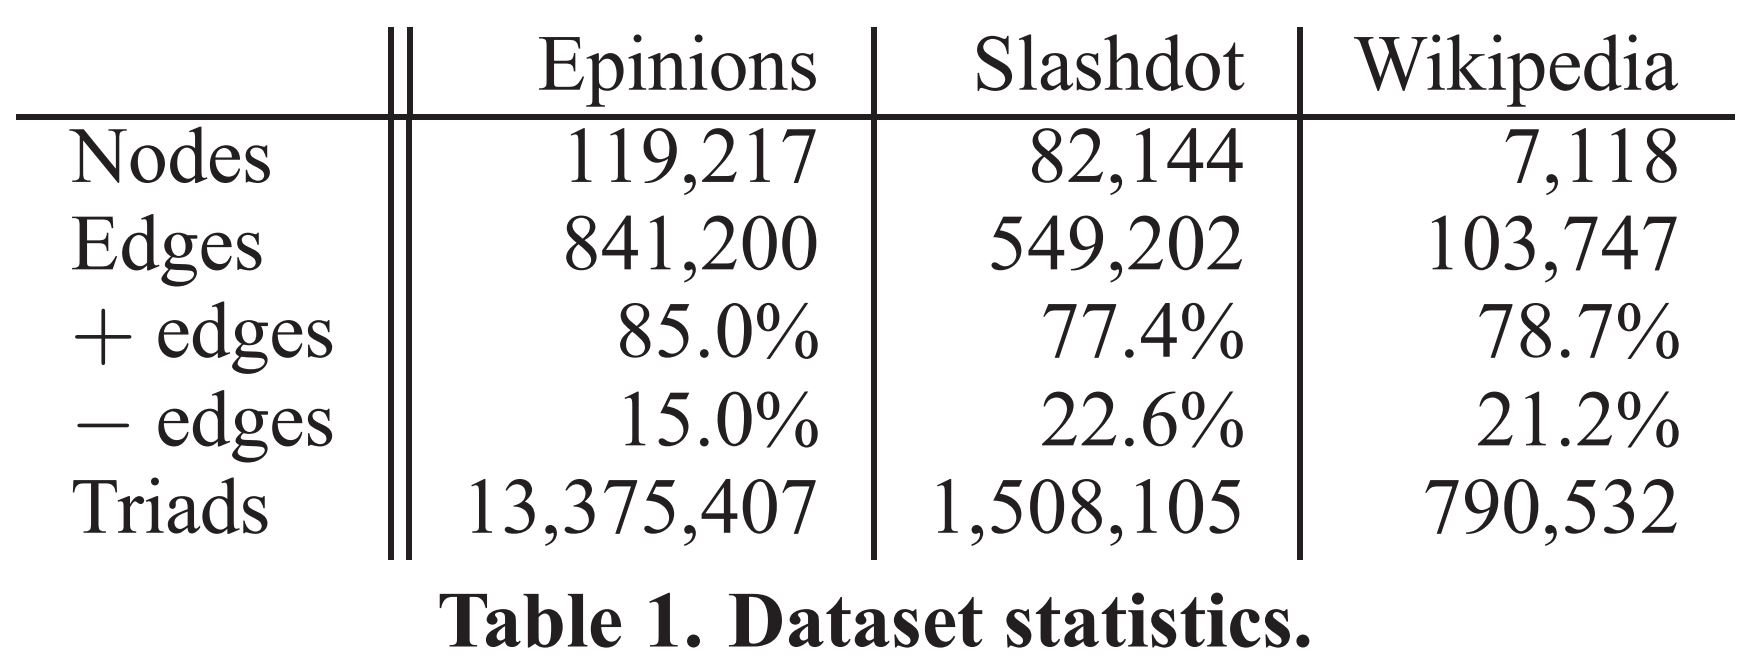

In [13]:
Image('./images/table1.jpg', width=400,height=300) 

In [14]:
dataset_statistics = pd.DataFrame(index=datasets.keys())

#### Nodes <a class="anchor" id="nodes"></a>

The datasets take the form of lists of edges. Given our assumptions from above, the number of nodes in each network is then naturally given by the number of unique nodes connected by these links.

In [15]:
def calculate_nb_nodes(dataset):
    # Calculate the number of unique edges 
    return len(np.unique(dataset.to_numpy()[:,:2]))

dataset_statistics['Nodes'] = [calculate_nb_nodes(dataset) for dataset in datasets.values()]
dataset_statistics

,Nodes
Epinions,131580
Slashdot,82140
Wikipedia,7115
Reddit,67180


#### Edges <a class="anchor" id="edges"></a>

The number of edges corresponds just the number of rows in each dataset. Note that we already removed multi-edges and self-connections.

In [16]:
def calculate_nb_edges(dataset):
    # Calculate the number of unique links. The weight of the connection is not considered.
    return len(np.unique(dataset.to_numpy()[:,:2],axis=0))

dataset_statistics['Edges'] = [calculate_nb_edges(dataset) for dataset in datasets.values()]
dataset_statistics

,Nodes,Edges
Epinions,131580,840799
Slashdot,82140,549202
Wikipedia,7115,103689
Reddit,67180,339643


#### Fraction of positive and negative edges <a class="anchor" id="fractions"></a>

Now, the fraction of positive and negative *Signs* of the edges is calculated.

In [17]:
# count positive and negative edges
dataset_statistics['+ edges'] = [np.count_nonzero(dataset['Sign'] == +1) for dataset in datasets.values()]
dataset_statistics['- edges'] = [np.count_nonzero(dataset['Sign'] == -1) for dataset in datasets.values()]
# divide total number of edges
dataset_statistics[['+ edges','- edges']] = \
                        dataset_statistics[['+ edges','- edges']].div(dataset_statistics.Edges, axis='index')
dataset_statistics

,Nodes,Edges,+ edges,- edges
Epinions,131580,840799,0.853,0.147
Slashdot,82140,549202,0.774,0.226
Wikipedia,7115,103689,0.788,0.212
Reddit,67180,339643,0.925,0.075


#### Triads <a class="anchor" id="triads"></a>

Counting the number of triads is somewhat more challenging. The function bellow does so by first calculating the list of neighbors for each node. Then it iterates through all nodes. For each of them it looks up its neighbors and the neighbors of each neighbor. Then it counts the number of nodes that are both neighbor and neighbor's neighbor to the original node - another definition of a triad. This yields *six* times the numbers of triads. For each node, the number of triads it participates in is counted *twice* since being a neighbor is a bidirectional connection. And the same triad is counted once for all *three* nodes that participate in it.

In [18]:
def get_nb_triads(dataset):
    """This function calculates the number of triads in a dataset"""
    
    # extracting edges from dataset
    edges=dataset.to_numpy()[:,:2]
    # remove non-unique edges - see discussion on edge count
    edges=np.unique(edges,axis=0)
    # remove edges of nodes with themselves
    edges=edges[edges[:,0]!=edges[:,1]]
    
    # listing neighbors for each node
    neighbors = [[] for i in range(np.max(edges)+1)]
    for [u,v] in edges:
        neighbors[u]+=[v]
        neighbors[v]+=[u]
    
    # iterating through nodes and counting nodes that are both neighbor and neighbor's neighbor to original node
    triads = 0    
    nodes = np.unique(edges.flatten())
    for node in nodes:
        neighbors_node = neighbors[node]
        neighbors_neighbours = np.concatenate([neighbors[neighbor] for neighbor in neighbors_node])
        triads+=sum([np.count_nonzero(neighbors_neighbours==neighbor) for neighbor in neighbors_node])
    # correcting for overcounting
    assert triads%6 == 0
    return triads//6

Although this is an efficient way of calculating the number of triads, it still takes a few minutes to do so. Ideally, the result is therefore stored to file. If such an output file exists, the result is read from there. Otherwise, the triads are counted and the result gets stored.

In [19]:
PATH_TRIAD_COUNT = PATH_OUTPUT_FOLDER + "triad_count.npy"

In [20]:
# If the output file exists, the result is read from there.
if os.path.isfile(PATH_TRIAD_COUNT): 
    dataset_statistics['Triads'] = np.load(PATH_TRIAD_COUNT)
else:
    dataset_statistics['Triads'] = [int(get_nb_triads(dataset)) for dataset in datasets.values()]
    np.save(PATH_TRIAD_COUNT,dataset_statistics['Triads'].to_numpy())
dataset_statistics

,Nodes,Edges,+ edges,- edges,Triads
Epinions,131580,840799,0.853,0.147,13317672
Slashdot,82140,549202,0.774,0.226,1508105
Wikipedia,7115,103689,0.788,0.212,790532
Reddit,67180,339643,0.925,0.075,4077337


The Reddit dataset differs from the others in that a greater portion of its edges are positive. What might sound surprising at first glance is probably a consequence of attributing a plus edge to positve and [*neutral*](https://snap.stanford.edu/data/soc-RedditHyperlinks.html) results of sentiment analysis. Note also that the Reddit graph contains more triad despite having fewer edges than the Slashdot graph.

### Triad statistics <a class="anchor" id="triadStatistics"></a>

In the following, the analysis to generate [Table 3](#table3) as in milestone P4 is performed on all datasets.

<a id='table1'></a>

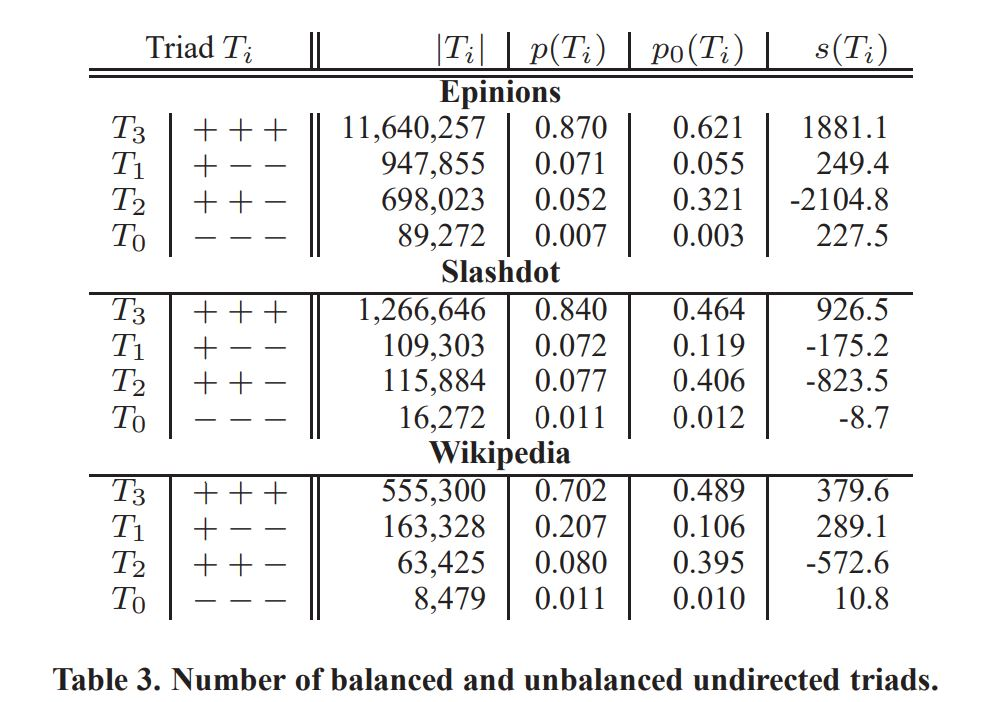

In [21]:
Image('./images/table3.jpg', width=400,height=300)

#### |$T_i$| <a class="anchor" id="T_i"></a>

For replicating *Table 1*, I already wrote a function, which counts the number of triads in a given network. Here, I need to keep track of the signs of the edges that make up those triads as well. The function bellow is an adapted version of the previous triad count function that does so.

First, it again generates the list of neighbors for each node. In addition, a list of the signs of the corresponding edges is created (-1s are stored as 0s to facilitate keeping track of the number of positive edges in a triad). The function then iterates through all nodes. For each of them it looks up its neighbors and the neighbors of each neighbor. It also counts the number of positive edges out of two edges for each triplet *node-neighbor-neighbor's neighbor*. Finally, for all nodes that are both neighbor and neighbor's neighbor to the original node, it computes the number of positive edges in this corresponding triad. This yields again *six* times the count for each triad type. For each node, the number of triads it participates in is counted *twice* since being a neighbor is a bidirectional connection. And the same triad is counted once for all *three* nodes that participate in it.

In [22]:
from collections import Counter

def get_nb_triads_by_type(dataset):
    """This function calculates the number of triads in a dataset"""
    
    # remove non-unique edges - see discussion on edge count and convert to numpy
    edges = dataset.drop_duplicates(subset=['FromNodeId', 'ToNodeId'], keep='last').to_numpy()
    # remove edges of nodes with themselves
    edges=edges[edges[:,0]!=edges[:,1]]

    # listing neighbors for each node and the signs of the corresonding connections
    neighbors = [[] for i in range(np.max(edges)+1)]
    signs = [[] for i in range(np.max(edges)+1)]

    for [u,v,s] in edges:
        neighbors[u]+=[v]
        neighbors[v]+=[u]
        signs[u]+=[max(0,s)]
        signs[v]+=[max(0,s)]
    
    
    # iterating through nodes and for each node that is both neighbor and neighbor's neighbor to original node 
    # counting incrementing the count of the corresponding triad type
    triad_counter = Counter() 
    nodes = np.unique(edges[:,:2].flatten())
    
    with progressbar.ProgressBar(max_value=nodes.shape[0]) as bar:
        for node in nodes:
            neighbors_node, signs_node = neighbors[node],signs[node]
            neighbors_neighbours = np.concatenate([neighbors[neighbor] for neighbor in neighbors_node])
            neighbors_signs = np.concatenate([np.array(signs[neighbor])+sign \
                                              for (neighbor,sign) in zip(neighbors_node,signs_node)])
            for (neighbor,sign) in zip(neighbors_node,signs_node):
                triad_counter+=Counter(neighbors_signs[neighbors_neighbours==neighbor]+sign)
        # converting to dataframe and correcting for overcounting
        triad_counter = pd.DataFrame.from_dict(triad_counter, orient='index',columns=['|T_i|'])//6
        triad_counter.index.name = '#+edges'
    return triad_counter

In [23]:
PATH_TRIAD_COUNT_BY_TYPE = PATH_OUTPUT_FOLDER + "triad_count_by_type_"

In [24]:
# If the output file exists, the result is read from there.
triad_statistics = dict()
for key, dataset in datasets.items():
    if os.path.isfile(PATH_TRIAD_COUNT_BY_TYPE+key+".pkl"):
        triad_statistics[key] = pd.read_pickle(PATH_TRIAD_COUNT_BY_TYPE+key+".pkl")
    else:
        triad_statistics[key] = get_nb_triads_by_type(dataset)
        triad_statistics[key].to_pickle(PATH_TRIAD_COUNT_BY_TYPE+key+".pkl")
    # print triad count by type
    print(key+" :\n", triad_statistics[key], end="\n\n")

Epinions :
             |T_i|
#+edges          
3        11616708
1          688557
2          924739
0           87668

Slashdot :
            |T_i|
#+edges         
3        1266646
1         115884
2         109303
0          16272

Wikipedia :
           |T_i|
#+edges        
3        555300
1         63425
2        163328
0          8479

Reddit :
            |T_i|
#+edges         
3        2841801
2        1023576
1         197192
0          14768



We introduce a DataFrame that stores features of datasets such as the number of triads per dataset. A quick sanity check shows that we get the same counts as above.

In [25]:
datasets_features = pd.DataFrame([sum(table['|T_i|']) for table in triad_statistics.values()],index=datasets.keys(),
                               columns=['#Triads'])
# Check that I get the same total number of triads as before
pd.testing.assert_series_equal(dataset_statistics['Triads'],datasets_features['#Triads'],
                               check_dtype=False,check_names=False)
datasets_features

,#Triads
Epinions,13317672
Slashdot,1508105
Wikipedia,790532
Reddit,4077337


#### $p(T_i)$ <a class="anchor" id="p(T_i)"></a>

The next column contains the fraction of triads of type $T_i$. It is a simple division of the number of triads for each type by the total number of triads in a given network.

In [26]:
for (key, table),nb_triads in zip(triad_statistics.items(),datasets_features['#Triads']):
    table['p(T_i)'] = table['|T_i|']/nb_triads
    print(key+" :\n",table,end="\n\n")

Epinions :
             |T_i|  p(T_i)
#+edges                  
3        11616708   0.872
1          688557   0.052
2          924739   0.069
0           87668   0.007

Slashdot :
            |T_i|  p(T_i)
#+edges                 
3        1266646   0.840
1         115884   0.077
2         109303   0.072
0          16272   0.011

Wikipedia :
           |T_i|  p(T_i)
#+edges                
3        555300   0.702
1         63425   0.080
2        163328   0.207
0          8479   0.011

Reddit :
            |T_i|  p(T_i)
#+edges                 
3        2841801   0.697
2        1023576   0.251
1         197192   0.048
0          14768   0.004



#### $p_0(T_i)$ <a class="anchor" id="p_0(T_i)"></a>

For the calculation of the *a priori probability of $T_i$*, we need to know the fraction of of positive edges in the network $p$. This was already calculated above and can be recycled here.

In [27]:
def calculate_frac_pos_edges(dataset):
    # Calculate the number of unique links. The weight of the connection is not considered.
    unique_edges = dataset.drop_duplicates(subset=['FromNodeId', 'ToNodeId'],keep='last')
    return np.count_nonzero(unique_edges['Sign'] == +1)/len(unique_edges)

datasets_features['p'] = [calculate_frac_pos_edges(dataset) for dataset in datasets.values()]
datasets_features

,#Triads,p
Epinions,13317672,0.853
Slashdot,1508105,0.774
Wikipedia,790532,0.788
Reddit,4077337,0.925


The *a priori* probability of $T_i$ based on sign distribution, $p_0(T_i)$, is given by a binomial distribution:
$$p_0(T_i)   = {n \choose k} p^k (1-p)^{ n-k}$$
, where $n=3$ is the number of edges per triad, $k$ is the number of positive edges in the given triad type, and $p$ is the fraction of positive edges in the entire network, which is asumed to be the *a priori* probability that an edge is positive.

In [28]:
from scipy.stats import binom
for (key, table),p in zip(triad_statistics.items(),datasets_features['p']):
    table['p0(T_i)'] = binom.pmf(table.index.get_level_values('#+edges'), 3, p)
    print(key+" :\n",table,end="\n\n")

Epinions :
             |T_i|  p(T_i)  p0(T_i)
#+edges                           
3        11616708   0.872    0.620
1          688557   0.052    0.055
2          924739   0.069    0.321
0           87668   0.007    0.003

Slashdot :
            |T_i|  p(T_i)  p0(T_i)
#+edges                          
3        1266646   0.840    0.464
1         115884   0.077    0.119
2         109303   0.072    0.406
0          16272   0.011    0.012

Wikipedia :
           |T_i|  p(T_i)  p0(T_i)
#+edges                         
3        555300   0.702    0.489
1         63425   0.080    0.106
2        163328   0.207    0.395
0          8479   0.011    0.010

Reddit :
            |T_i|  p(T_i)  p0(T_i)
#+edges                          
3        2841801   0.697    0.791
2        1023576   0.251    0.193
1         197192   0.048    0.016
0          14768   0.004    0.000



#### $s(T_i)$ <a class="anchor" id="s(T_i)"></a>

The surprise, $s(T_i)$, of finding a number, $|T_i|$, of a given triad type, $T_i$, is given by the following formula:
$$s(T_i)=\frac{|T_i|-E[|T_i|]}{\sqrt{\Delta p_0(T_i)(1-p_0(T_i))}}$$

In [29]:
for (key, table),nb_triads in zip(triad_statistics.items(),datasets_features['#Triads']):
    table['s(T_i)']=(table['|T_i|']-table['p0(T_i)']*nb_triads)\
                    /np.sqrt(nb_triads*table['p0(T_i)']*(1-table['p0(T_i)']))
    print(key+" :\n",table,end="\n\n")

Epinions :
             |T_i|  p(T_i)  p0(T_i)     s(T_i)
#+edges                                      
3        11616708   0.872    0.620  1,893.701
1          688557   0.052    0.055    -58.317
2          924739   0.069    0.321 -1,966.401
0           87668   0.007    0.003    220.352

Slashdot :
            |T_i|  p(T_i)  p0(T_i)   s(T_i)
#+edges                                   
3        1266646   0.840    0.464  926.538
1         115884   0.077    0.119 -158.663
2         109303   0.072    0.406 -834.445
0          16272   0.011    0.012   -8.695

Wikipedia :
           |T_i|  p(T_i)  p0(T_i)   s(T_i)
#+edges                                  
3        555300   0.702    0.489  379.153
1         63425   0.080    0.106  -75.108
2        163328   0.207    0.395 -342.545
0          8479   0.011    0.010   10.936

Reddit :
            |T_i|  p(T_i)  p0(T_i)   s(T_i)
#+edges                                   
3        2841801   0.697    0.791 -469.323
2        1023576   0.251    0.193  

### Summary Replications <a class="anchor" id="summaryReplications"></a>

In [30]:
from tabulate import tabulate

def pretty_print(table):
    ''' This function generates a pretty print for our results '''
    
    for key in table:
        if key == 'Reddit':
            new_index = [3, 1, 2, 0]
            table[key] = table[key].reindex(new_index)
        table[key] = table[key].rename(index={3: 'T₃', 1: 'T₁', 2: 'T₂', 0: 'T₀'})
        table[key] = table[key].rename(columns = {'#+edges ':'', '|T_i|':'|Tᵢ|', 'p(T_i)': 'p(Tᵢ)', 'p0(T_i)': 'p₀(Tᵢ)',
                                                  's(T_i)' : 's(Tᵢ)'})

    
    df_names = ['Epinions', 'Slashdot', 'Wikipedia', 'Reddit']

    print('\033[1m'+'\t\tPaper table 3 - reproduced.\n')
    print ('\033[0m')

    for key in table:
        print('\t\t\t\033[1m' + key + '\033[0m')
        print(tabulate(table[key], headers = 'keys', tablefmt="fancy_grid", numalign="right", 
                       floatfmt=(None,'.0f','.3f','.3f','.1f')))
        print('\n')

In [31]:
pretty_print(triad_statistics)

		Paper table 3 - reproduced.


			Epinions
╒═══════════╤══════════╤═════════╤══════════╤═════════╕
│ #+edges   │     |Tᵢ| │   p(Tᵢ) │   p₀(Tᵢ) │   s(Tᵢ) │
╞═══════════╪══════════╪═════════╪══════════╪═════════╡
│ T₃        │ 11616708 │   0.872 │    0.620 │  1893.7 │
├───────────┼──────────┼─────────┼──────────┼─────────┤
│ T₁        │   688557 │   0.052 │    0.055 │   -58.3 │
├───────────┼──────────┼─────────┼──────────┼─────────┤
│ T₂        │   924739 │   0.069 │    0.321 │ -1966.4 │
├───────────┼──────────┼─────────┼──────────┼─────────┤
│ T₀        │    87668 │   0.007 │    0.003 │   220.4 │
╘═══════════╧══════════╧═════════╧══════════╧═════════╛


			Slashdot
╒═══════════╤═════════╤═════════╤══════════╤═════════╕
│ #+edges   │    |Tᵢ| │   p(Tᵢ) │   p₀(Tᵢ) │   s(Tᵢ) │
╞═══════════╪═════════╪═════════╪══════════╪═════════╡
│ T₃        │ 1266646 │   0.840 │    0.464 │   926.5 │
├───────────┼─────────┼─────────┼──────────┼─────────┤
│ T₁        │  115884 │   0.077 │    0.119 │  -158.

The Reddit dataset does not follow the same pattern as the other datasets when it comes to triad under- and overrepresentation of certain triad types. Curiously, triads with all-positive edges are underrepresented and all other types are overrepresented. This goes against both structural balance theory and its weaker variant (see [original paper](https://doi.org/10.1145/1753326.1753532) by Leskovec et al. for context). One could argue that a subreddit is not a person and thus not subjected to the same rules of social psychology. But it would have been quite plausible that the principle that "the friend of my friend is my frient" applies also to groups. We don't see any particular reason why two groups which are friendly with a third group should not be friendly with one another. Further research is needed.

## Analyze properties of the networks <a class="anchor" id="properties"></a>

In [32]:
import networkx as nx
from networkx.convert_matrix import from_pandas_edgelist
from networkx.algorithms.approximation import clustering_coefficient
from networkx import average_shortest_path_length
import random
import pickle

def bootstrap_CI_mean(data, nbr_draws = 1000):
    """ bootstrap_CI_mean returns a 95% CI of the mean of 'data'
    data
    nbr_draws: number of draws that should be performed to compute the bootstraped CI
    """ 
    sample_size = len(data)
    samples = data.sample(n = sample_size*nbr_draws, replace = True, random_state=0).values\
              .reshape((sample_size,nbr_draws))
    means = np.mean(samples,axis=0)
    return np.asarray([np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)])

# -------------------

def compute_properties(datasets):
    graphs = {}
    for key in datasets:
        G = nx.from_pandas_edgelist(datasets[key][['FromNodeId','ToNodeId']], source = 'FromNodeId', 
                                    target = 'ToNodeId')
        graphs[key] = G
        
    properties = {}
    for key in datasets:
        properties[key] = {}

    for key in graphs:
        clustering = nx.clustering(graphs[key])
        properties[key]['mean_clustering'] = np.array(list(clustering.values())).mean()
        properties[key]['95%CI_clustering'] = bootstrap_CI_mean(pd.Series(list(clustering.values())))
        
    ccs = []
    for key in graphs:
        ccs_ = max(nx.connected_components(graphs[key]), key = len)
        ccs.append([ccs_, len(ccs_)])
    print('The fraction of connected components for each dataset are the following:')
    print(np.array(ccs)[:,1]/dataset_statistics['Nodes']*100)
    print('\nSince three of our four graphs arent connected, we will compute the average shortest path length for the bigger connected components each time.\n')
    
    sample_nb = 200

    for idx, key in enumerate(graphs):
        print(key)
        random.seed(5)
        sample = random.sample(range(0, len(ccs[idx][0])-1),sample_nb)
        sources = list(ccs[idx][0])
        biggest_graph = graphs[key].subgraph(ccs[idx][0]).copy()

        with progressbar.ProgressBar(max_value=sample_nb) as bar:
            aspl = []
            for idx, samp in enumerate(sample):
                aspl.append(np.array(list(nx.shortest_path_length(biggest_graph, source = sources[samp]).values())))
                bar.update(idx+1)
        properties[key]['mean_aspl'] = np.mean(np.concatenate(aspl, axis=0))
        properties[key]['95%CI_aspl'] = bootstrap_CI_mean(pd.Series(np.concatenate( aspl, axis=0)), nbr_draws = 10)

    return properties

In [33]:
PATH_PROPERTIES = PATH_OUTPUT_FOLDER + "properties.pickle"

In [34]:
if os.path.isfile(PATH_PROPERTIES):
    with open(PATH_PROPERTIES, 'rb') as f:
        properties = pickle.load(f)
else:
    properties = compute_properties(datasets)

In [35]:
clustering = []
aspl = []

for key in properties:
    clustering.append([key, properties[key]['mean_clustering'], properties[key]['95%CI_clustering']])
    aspl.append([key, properties[key]['mean_aspl'], properties[key]['95%CI_aspl']])

In [36]:
def pretty_print_property(table, clustering = False):
    ''' This function generates a pretty print for our results '''
    if clustering:
        table = table.rename(columns = {1:'Clustering coefficient', 2:'95% CI'})
    else:
        table = table.rename(columns = {1:'Average shortest path length', 2:'95% CI'})


    print(tabulate(table, headers = 'keys', tablefmt="fancy_grid", numalign="right"))
    print('\n')

In [37]:
clustering = pd.DataFrame(clustering).set_index(0)
clustering.index.names = ['Dataset']
aspl = pd.DataFrame(aspl).set_index(0)
aspl.index.names = ['Dataset']

In [38]:
pretty_print_property(clustering, clustering = True)
pretty_print_property(aspl)

╒═══════════╤══════════════════════════╤═════════════════════════╕
│ Dataset   │   Clustering coefficient │ 95% CI                  │
╞═══════════╪══════════════════════════╪═════════════════════════╡
│ Epinions  │                 0.128186 │ [0.12678899 0.12961191] │
├───────────┼──────────────────────────┼─────────────────────────┤
│ Slashdot  │                0.0587871 │ [0.05737831 0.0599923 ] │
├───────────┼──────────────────────────┼─────────────────────────┤
│ Wikipedia │                 0.140898 │ [0.13658216 0.14579731] │
├───────────┼──────────────────────────┼─────────────────────────┤
│ Reddit    │                 0.216967 │ [0.21445482 0.21957991] │
╘═══════════╧══════════════════════════╧═════════════════════════╛


╒═══════════╤════════════════════════════════╤═════════════════════════╕
│ Dataset   │   Average shortest path length │ 95% CI                  │
╞═══════════╪════════════════════════════════╪═════════════════════════╡
│ Epinions  │                         4.15

TO DO: 
- maybe have a look at Graph Laplacian
- plot degree distribution on log-log plot
- small wold properties: small-coefficient $\sigma = \frac{\frac{C}{C_r}}{\frac{L}{L_r}}$, if $\sigma>1$ (or equivalently $C>>C_r$ and $L\approx L_r$), [the network is small-world](https://en.wikipedia.org/wiki/Small-world_network#Properties_of_small-world_networks).

In [Signed Netwoks in Social Media](https://doi.org/10.1145/1753326.1753532), Leskovec *et al.* discuss all-positive and all-negative subnetworks. And propose the possowing interpretation:
    
    [B]oth the all-positive and all-negative networks are less well-connected than expected, in the sense that their largest connected components are smaller than those of their randomized counterparts. While  this may seem initially counterintuitive, one possible interpretation is as follows. The giant components of  real social networks are believed to consist of densely connected clusters linked by less embedded ties. The  all-positive and all-negative networks in the real (rather than randomized) datasets are each biased toward  one side of this balance: the all-positive networks have dense clusters without the bridging provided by less embedded ties, while the all-negative networks lack a sufficient abundance of dense clusters to sustain a large component.

In the following, we explore this hypothesis. We perform [spectral clustering](https://en.wikipedia.org/wiki/Spectral_clustering) and calcluate the positive and negative edge sign fraction of inter- and intracluster links. According to the interpretation from above, the intracluster edge signs are expected to be more positive and the intercluster edge signs are expected to be more negative than the [previously](#fractions) determined global value.

Note that the networks are not fully connected. Thus, we first identify the largest connected component in each network before performing the clustering analysis.

In [39]:
def print_characteristics(G):
    """A function that prints the number of edges and nodes in a given graph."""
    print("\t#Nodes : {}\n\t#Edges : {}".format(G.number_of_nodes(),G.number_of_edges()))

# Isolating the largest connected component in a graph
connected_graphs = {}
for key in datasets:
    print(key," :\n\tfull graph:")
    # Generate an undirected signed graph from an edgelist
    G = nx.from_pandas_edgelist(datasets[key][['FromNodeId','ToNodeId','Sign']], source = 'FromNodeId',
                                target = 'ToNodeId', edge_attr = 'Sign')
    print_characteristics(G)
    # Generate the subgraph from the largest connected component
    G = G.subgraph(max(nx.connected_components(G), key = len))
    print("\tlargest connected subgraph:")
    print_characteristics(G)
    connected_graphs[key] = G

Epinions  :
	full graph:
	#Nodes : 131580
	#Edges : 711210
	largest connected subgraph:
	#Nodes : 119130
	#Edges : 704267
Slashdot  :
	full graph:
	#Nodes : 82140
	#Edges : 500481
	largest connected subgraph:
	#Nodes : 82140
	#Edges : 500481
Wikipedia  :
	full graph:
	#Nodes : 7115
	#Edges : 100762
	largest connected subgraph:
	#Nodes : 7066
	#Edges : 100736
Reddit  :
	full graph:
	#Nodes : 67180
	#Edges : 309667
	largest connected subgraph:
	#Nodes : 65648
	#Edges : 308839


The complexity of the spectral clustering algorithm is ~ O(n³) in the number of nodes. It is therefore not suitable for the larger networks. Instead of sampling the larger graphs (from Epinions, Slashdot, and Reddit), which might alter the result, we ran it only on the wikipedia dataset. Because the real number of clusters is unknown, we vary this parameter.

In [40]:
import sklearn
from sklearn.cluster import SpectralClustering

def calculate_intra_inter_cluster_edge_sign_fraction(connected_graph, number_of_clusters):
    """This function performs spectral clustering of a graph and returns the fraction of positive
       and negative edges among links between and within clusters."""
    
    # Initialize DataFrame to store results
    edge_stats = pd.DataFrame({('intra','+ edges'):[], ('intra','- edges'):[],
                               ('inter','+ edges'):[], ('inter','- edges'):[]})
    edge_stats.columns.names = ('Edge Type','Sign')
    edge_stats.index.name= "Number of Clusters"
    
    # calculate adjacency matrix
    adj_matrix = nx.to_scipy_sparse_matrix(connected_graph)
    
    for n_clusters in number_of_clusters:
        # perform spectral clustering
        clustering = SpectralClustering(affinity = 'precomputed', assign_labels = "discretize", random_state = 42,
                                      n_clusters=n_clusters).fit_predict(adj_matrix)
        # Store clusters as dictionary - clusterID : [node1,...]
        clusters = {clusterID : [i for i,x in enumerate(clustering) if x==clusterID] for clusterID in set(clustering)}
        # Generate intra- and intercluster subgraphs
        G_intra = nx.Graph()
        G_inter = connected_graph.copy()
        # Add/remove intracluster connections
        for nodes_cluster in clusters.values():
            subgraph_cluster = connected_graph.subgraph(nodes_cluster)
            G_intra.update(subgraph_cluster)
            for edge in list(subgraph_cluster.edges):
                G_inter.remove_edge(*edge)
        # Store fraction of positive and negative edges
        edge_count_intra = Counter(list(nx.get_edge_attributes(G_intra,"Sign").values()))
        edge_count_inter = Counter(list(nx.get_edge_attributes(G_inter,"Sign").values()))
        intra_plus = edge_count_intra[1]/G_intra.size()
        intra_minus = edge_count_intra[-1]/G_intra.size()
        inter_plus = edge_count_inter[1]/G_inter.size()
        inter_minus = edge_count_inter[-1]/G_inter.size()
        """
        print(key," :\n\tintracluster\n\t\t+ edges : {:0.3f}\n\t\t- edges : {:0.3f}".format(intra_plus,intra_minus),
              "\n\tintercluster\n\t\t+ edges : {:0.3f}\n\t\t- edges : {:0.3f}".format(inter_plus,inter_minus))
        """
        edge_stats.loc[n_clusters] = [intra_plus,intra_minus,inter_plus,inter_minus]
    return edge_stats

In [41]:
# Set output path
PATH_EDGE_SIGN_FRACTION_INTER_INTRA_CLUSTER = PATH_OUTPUT_FOLDER + "intra_inter_cluster_edge_signs.pkl"

# Only the graph from wikipedia si small enough for the spectral clustering analysis.
connected_graph = connected_graphs["Wikipedia"]
# Set the number of clusters to try in which the graph is divided.
number_of_clusters = np.arange(10,101,1)

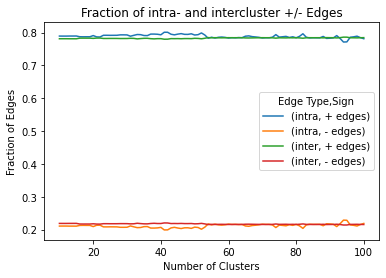

In [42]:
# If the output file exists, the result is read from there.
if os.path.isfile(PATH_EDGE_SIGN_FRACTION_INTER_INTRA_CLUSTER):
    edge_stats = pd.read_pickle(PATH_EDGE_SIGN_FRACTION_INTER_INTRA_CLUSTER)
else:
    edge_stats = calculate_intra_inter_cluster_edge_sign_fraction(connected_graph, number_of_clusters)
    edge_stats.to_pickle(PATH_EDGE_SIGN_FRACTION_INTER_INTRA_CLUSTER)

# Show intra- and intercluster positive and negative edge fractions
edge_stats.plot()
plt.ylabel("Fraction of Edges")
plt.title("Fraction of intra- and intercluster +/- Edges")
plt.show()

Small world properties

## Logistic regression <a class="anchor" id="logreg"></a>

To do: generate features which are expected to have more or less predictive power depending on the different theoretical considerations (e.g. the number of common neighbors, a balance and a status score based on the triads that the edge is involved in, etc.)

Here we want to build a model to predict the sign of a given edge. We consider multiple features including number of common neighbors and features created from the different combinations of directed signed triads.

In [43]:
# Reload the data in case they have been modified
data_epinions = pd.read_table(PATH_TO_DATA+filename_epinions, 
                              names=["FromNodeId", "ToNodeId", "Sign"], comment='#')
data_slashdot = pd.read_table(PATH_TO_DATA+filename_slashdot, 
                              names=["FromNodeId", "ToNodeId", "Sign"], comment='#')
data_wikipedia = pd.read_table(PATH_TO_DATA+filename_wikipedia)
data_reddit = pd.concat(   [pd.read_table(PATH_TO_DATA+file, header=0,usecols=[0,1,4],
                                          names=["FromNodeId","ToNodeId","Sign"]) 
                                                        for file in filenames_reddit], ignore_index=True)
IDs, unique_usernames = pd.factorize(data_reddit[["FromNodeId","ToNodeId"]].values.flatten())
data_reddit[["FromNodeId","ToNodeId"]] = IDs.reshape(-1,2)

# The datasets are stored in a dictionary
datasets = {'Epinions' : data_epinions, 'Slashdot' : data_slashdot, 
            'Wikipedia' : data_wikipedia, 'Reddit' : data_reddit}
            
for key in datasets.keys():
    # remove non-unique edges - keep only the last of a set of multi-edges in the order they appear in the edge list.
    datasets[key] = datasets[key].drop_duplicates(subset=['FromNodeId', 'ToNodeId'], keep='last')
    # remove edges of nodes with themselves
    datasets[key] = datasets[key][datasets[key]['FromNodeId']!=datasets[key]['ToNodeId']]
    
datasets = [datasets[key] for key in datasets.keys()]

### Generate feature matrix

First we generate the matrix $A$ for each dataset, with entry $(i,j)$ equals to zero if there isn't an edge from $i$ to $j$ and $A(i,j)$ equal to the weight of the edge $i$->$j$ if it exists. Besides, we generate similar matrix $A_+$ and $A_-$ with respectively only positive weights or negative weights, i.e. $A = A_+ + A_-$.

In [44]:
def generate_matrices_pos_neg(datasets):
    matrices_pos = []
    matrices_neg = []
    matrices = []
    for idx, data in enumerate(datasets):
        dimension = max(max(data['FromNodeId'].values), max(data['ToNodeId'].values))+1
        matrix_pos = lil_matrix((dimension, dimension))
        matrix_neg = lil_matrix((dimension, dimension))
        matrix = lil_matrix((dimension, dimension))
        edges = data.to_numpy()
        for edge in edges:
            
            matrix[edge[0],edge[1]] = edge[2]
            if (edge[2] == 1):
                matrix_pos[edge[0],edge[1]] = edge[2]
            else:
                matrix_neg[edge[0],edge[1]] = edge[2]
                
        matrix_pos = csr_matrix(matrix_pos)
        matrices_pos.append(matrix_pos)
        
        matrix_neg = csr_matrix(matrix_neg)
        matrices_neg.append(matrix_neg)
        
        matrix = csr_matrix(matrix)
        matrices.append(matrix)
    
    return matrices, matrices_pos, matrices_neg

def compute_X(datasets):
    
    A, A_pos, A_minus = generate_matrices_pos_neg(datasets)

    X = np.empty((0,16))
    for i in range(len(A)):
        X_i = np.array([])
        dim = A_pos[i].shape[0]
        Xs = []

        # remove non-unique edges - see discussion on edge count and convert to numpy
        edges = datasets[i].drop_duplicates(subset=['FromNodeId', 'ToNodeId'], keep='last').to_numpy()
        # remove edges of nodes with themselves
        edges=edges[edges[:,0]!=edges[:,1]]
        edges=edges[:,[0,1]]
        
        for pair_feature in itertools.product([A_pos[i],A_pos[i].T,A_minus[i],A_minus[i].T], repeat=2):
            feature = (pair_feature[0]@pair_feature[1]).tocsr()

            ### need to keep only the entries with existing edges
            feature = np.array(feature[edges[:,0],edges[:,1]])
            feature = feature.T
            if X_i.shape[0] == 0:
                X_i = feature
            else:
                X_i = np.hstack((X_i,feature))
        X = np.vstack((X,X_i)) # add up each feature matrix of the different datasets
    return X

Now we generate the feature matrix $X$ representing each possible combination for a directed triad. Given an edge $(i,j)$, if $k$ is the third node forming the triad, since $(i,k)$ can take 2 different values (-1 or +1) and can be directed in both direction, there exists 4 different combinations for the $(i,k)$. Similarly there exists 4 configuration for $(j,k)$. Thus, there are 16 different configurations possible for a triad, given an edge.
These configurations for edge $(i,j)$ are nothing else than the entry $(i,j)$ of different matrices resulting from combination of the multiplication of two matrices in {$A_+$, $A_-$, $A_+^T$, $A_-^T$}. 

In [45]:
X = compute_X(datasets)

Now we add features that do not specificaly come from a triad disposition. We add for each edge $(i,j)$ the proportion of positive edges directed from/to $i$/$j$. These 4 features should be useful for prediction of edges that are not contained in a triad. We excluded the edge $i$->$j$ itself from its ratio.

In [46]:
def get_nodes_degree(dataset):
    """This function computes the number of common out neighbors in a dataset"""
    
    # extracting edges from dataset
    edges=dataset.to_numpy()
    # remove non-unique edges - see discussion on edge count
    edges=np.unique(edges,axis=0)
    # remove edges of nodes with themselves
    edges=edges[edges[:,0]!=edges[:,1]]
    
    # count max(number out neighbors -1,0) for each node
    out_degree = -1*np.ones(np.max(edges)+1)
    # count max(number in neighbors -1,0) for each node
    in_degree = -1*np.ones(np.max(edges)+1)
    # count max(number positive out neighbors -1,0) for each node
    positive_out = -1*np.ones(np.max(edges)+1)
    # count max(number positive in neighbors -1,0) for each node
    positive_in = -1*np.ones(np.max(edges)+1)
    
    for [u,v,w] in edges:
        out_degree[u]+=1
        in_degree[v]+=1
        
        if w == 1:
            positive_out[u]+=1
            positive_in[v]+=1
            
    out_degree[out_degree<0] = 0
    in_degree[in_degree<0] = 0
    positive_out[positive_out<0] = 0
    positive_in[positive_in<0] = 0
    
    ratio_out = np.divide(positive_out, out_degree, out=np.zeros_like(positive_out), where=out_degree!=0)
    ratio_in = np.divide(positive_in, in_degree, out=np.zeros_like(positive_in), where=in_degree!=0)
        
    return ratio_out,ratio_in

def more_features_X(datasets):
    
    X_ratio = np.empty((0,4))
    
    for idx, data in enumerate(datasets):
        ratio_out,ratio_in = get_nodes_degree(data)
        
        # extracting edges from dataset
        edges=data.to_numpy()[:,:2]
        # remove non-unique edges - see discussion on edge count
        edges=np.unique(edges,axis=0)
        # remove edges of nodes with themselves
        edges=edges[edges[:,0]!=edges[:,1]]
        
        # add 4 features: ratio_in, ratio out_ for i and j
        new_features = np.array([[ratio_out[u],ratio_in[u],ratio_out[v],ratio_in[v]] for [u,v] in edges])
        X_ratio = np.vstack((X_ratio,new_features))
        
    return X_ratio
    

In [47]:
X_ratio = more_features_X(datasets)

In [48]:
X = np.hstack((X,X_ratio))
sum_ = 0
for dataset in datasets:
    sum_ += dataset.shape[0]

assert sum_ == X.shape[0]

In [49]:
all_ = X.copy()
sum_ = 0
X_Epinions = X[0:datasets[0].shape[0]]
sum_ += datasets[0].shape[0]
X_Slashdot = X[sum_:sum_+datasets[1].shape[0]]
sum_+=datasets[1].shape[0]
X_Wikipedia = X[sum_:sum_+datasets[2].shape[0]]
sum_+=datasets[2].shape[0]
X_Reddit = X[sum_:sum_+datasets[3].shape[0]]

In [50]:
Xs = [X_Epinions, X_Slashdot, X_Wikipedia, X_Reddit, all_]

### Model and prediction

In [51]:
# compute associated y, which is the sign of each edge

ys = []
for i in range(len(datasets)):
    # remove non-unique edges - see discussion on edge count and convert to numpy
    edges = datasets[i].drop_duplicates(subset=['FromNodeId', 'ToNodeId'], keep='last').to_numpy()
    # remove edges of nodes with themselves
    edges=edges[edges[:,0]!=edges[:,1]]
    signs=edges[:,2]
    y = signs
    y[y==-1] = 0
    ys.append(signs)
    
ys.append(np.hstack(ys))

In [52]:
import itertools
classifier_penalty = ['l1', 'l2']
classifier_C = np.logspace(-6, 4, 20)
classifier_solver = ['liblinear', 'lbfgs']
parameters = [classifier_penalty, classifier_C, classifier_solver]
combinations = list(itertools.product(*parameters))

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.utils._testing import ignore_warnings 
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning 
import itertools

def optimization(combinations, Xs, ys):
# Evaluate the precison/recall with a cross validation (10 splits) and optimize the parameters using a standard
# grid search approach
    metrics = []

    with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
        with progressbar.ProgressBar(max_value=len(combinations)) as bar:
            for i, comb in enumerate(combinations):
                if comb[0] == 'l1' and comb[2] == 'lbfgs':
                    continue

                logistic = LogisticRegression(penalty = comb[0], C = comb[1], solver=comb[2])

                for idx, (X, y) in enumerate(zip(Xs, ys)):
                    try:
                        accuracy = cross_val_score(logistic, X, y, cv=10, scoring="accuracy")
                        precision = cross_val_score(logistic, X, y, cv=10, scoring="precision")
                        recall = cross_val_score(logistic, X, y, cv=10, scoring="recall")
                        roc_auc = cross_val_score(logistic, X, y, cv=10, scoring="roc_auc")
                        metrics.append([comb, idx, [accuracy, precision, recall, roc_auc]])
                    except:
                        print(idx)
                        print(comb)
                        pass

                bar.update(i+1)
    return metrics

In [54]:
def is_better (best, value):
    if np.mean(value[2][3]) > best[0]:
        best[0] = np.mean(value[2][3])
        best[1] = value
    return best
   
def get_best_parameters(metrics_all):
    best_epi = [0,[]]
    best_sls = [0,[]]
    best_wiki = [0,[]]
    best_reddit = [0,[]]
    best_all = [0,[]]

    for metric in metrics_all:
        if metric[1]==0:
            best_epi = is_better(best_epi, metric)
        elif metric[1]==1:
            best_sls = is_better(best_sls, metric)
        elif metric[1]==2:
            best_wiki = is_better(best_wiki, metric)
        elif metric[1]==3:
            best_reddit = is_better(best_reddit, metric)
        elif metric[1]==4:
            best_all = is_better(best_all, metric)

    bests = [best_epi, best_sls, best_wiki, best_reddit, best_all]
    best_metrics = []
    for idx, best in enumerate(bests):
        if len(best[1])>1:
            values = best[1][2]
            best_metrics.append([idx, best[1][0], np.mean(values[0]), 
                                 np.mean(values[1]), np.mean(values[2]), np.mean(values[3])])
    return best_metrics

In [55]:
PATH_METRICS = PATH_OUTPUT_FOLDER + "metrics.pickle"

if os.path.isfile(PATH_METRICS): 
    with open(PATH_METRICS, 'rb') as handle:
        best_metrics = pickle.load(handle)
else:
    best_metrics = get_best_parameters(optimization(combinations, Xs, ys))

In [53]:
best_metrics = get_best_parameters(optimization(combinations, Xs, ys))

 75% (3 of 4) |###################       | Elapsed Time: 0:13:31 ETA:   0:10:30

0
('l2', 100.0, 'lbfgs')
2
('l2', 100.0, 'lbfgs')
3
('l2', 100.0, 'lbfgs')


100% (4 of 4) |##########################| Elapsed Time: 0:14:59 Time:  0:14:59


4
('l2', 100.0, 'lbfgs')


In [56]:
best_metrics

[[0,
  ('l2', 0.00012742749857031334, 'lbfgs'),
  0.8990971468696769,
  0.8984518644935784,
  0.9946006953457249,
  0.9129309259889633],
 [1,
  ('l2', 0.00012742749857031334, 'lbfgs'),
  0.8001008263766748,
  0.7986787499935166,
  0.991916673535384,
  0.759101782328709],
 [2,
  ('l1', 0.11288378916846883, 'liblinear'),
  0.8315730132940186,
  0.8438687958693756,
  0.9655467907743704,
  0.8590932201786655],
 [3,
  ('l2', 2.6366508987303555e-06, 'lbfgs'),
  0.9243735283623018,
  0.925351755729696,
  0.9988158925252977,
  0.7139662859125188],
 [4,
  ('l2', 2.6366508987303555e-06, 'lbfgs'),
  0.852543392867567,
  0.852399318280923,
  0.9972406977575792,
  0.8217492863107481]]

In [57]:
edges_positive_all = (Xs[0].shape[0]*85.3 + Xs[1].shape[0]*77.4 + Xs[2].shape[0]*78.8 + 
                      Xs[3].shape[0]*92.5)/(Xs[4].shape[0])
edges_positive_all

83.89968445448808

## Visualization of the "preference profiles" of users <a class="anchor" id="SVD-PCA"></a>

### Matrix generation <a class="anchor" id="matrixgeneration"></a>

In a first time, we have to build matrices from which we will be able to perform SVD. Each row corresponds to an
individual, each column corresponds to the link they receive from other individuals. The 'weight' corresponds to the sum of edges signs between the two individuals.

In [58]:
# Reload the data in case they have been modified
data_epinions = pd.read_table(PATH_TO_DATA+filename_epinions, 
                              names=["FromNodeId", "ToNodeId", "Sign"], comment='#')
data_slashdot = pd.read_table(PATH_TO_DATA+filename_slashdot, 
                              names=["FromNodeId", "ToNodeId", "Sign"], comment='#')
data_wikipedia = pd.read_table(PATH_TO_DATA+filename_wikipedia)
data_reddit = pd.concat(   [pd.read_table(PATH_TO_DATA+file, header=0,usecols=[0,1,4],
                                          names=["FromNodeId","ToNodeId","Sign"]) 
                                                        for file in filenames_reddit], ignore_index=True)
IDs, unique_usernames = pd.factorize(data_reddit[["FromNodeId","ToNodeId"]].values.flatten())
data_reddit[["FromNodeId","ToNodeId"]] = IDs.reshape(-1,2)
datasets = [data_epinions, data_slashdot, data_wikipedia, data_reddit]

In [59]:
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.decomposition import TruncatedSVD

# ----------

def fill_matrix_for_row(row, matrix):
    matrix[row['ToNodeId'], row['FromNodeId']] += 1
    return row

# ----------

def generate_matrix(datasets):
    matrices = []
    for idx, data in enumerate(datasets):
        dimension = max(max(data['FromNodeId'].values), max(data['ToNodeId'].values))+1
        matrix = lil_matrix((dimension, dimension))
        edges = data.to_numpy()
        for edge in edges:
            matrix[edge[0],edge[1]] += edge[2]
        matrix = csr_matrix(matrix)
        matrices.append(matrix)
    return matrices

In [60]:
matrices = generate_matrix(datasets)

# Sanity check
for i, matrix in enumerate(matrices):
    assert matrix.sum() == datasets[i]['Sign'].sum()

### SVD <a class="anchor" id="svd"></a>

Now that we have generated our (sparse) matrices, we can perform svd to allow data dimensionality reduction.

In [61]:
def compute_svd(matrices):
    k = 10
    matrix_pca = []
    for idx, matrix in enumerate(matrices):
        svd = TruncatedSVD(k)
        matrix_transformed = svd.fit_transform(matrix)
        explained_variances = svd.explained_variance_ratio_
        matrix_pca.append([matrix_transformed, explained_variances])
    return matrix_pca

In [62]:
matrix_pca = compute_svd(matrices)

In [63]:
def plot_svd(matrices):
    
    fig, axs = plt.subplots(2, 2, figsize=(8,8))
    axs[0, 0].scatter(matrices[0][0][:,0], matrices[0][0][:,1])
    axs[0, 0].set_title('Epinions')
    axs[0, 1].scatter(matrices[1][0][:,0], matrices[1][0][:,1])
    axs[0, 1].set_title('Slashdot')
    axs[1, 0].scatter(matrices[2][0][:,0], matrices[2][0][:,1])
    axs[1, 0].set_title('Wikipedia')
    axs[1, 1].scatter(matrices[3][0][:,0], matrices[3][0][:,1])
    axs[1, 1].set_title('Reddit')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

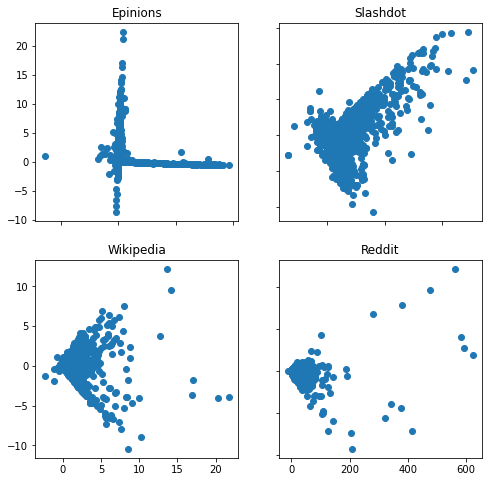

In [64]:
plot_svd(matrix_pca)

We also tried to to perfom the exact same thing with the data originating from the logistic regression.

In [65]:
from sklearn.decomposition import PCA

def compute_pca(matrices):
    k = 10
    matrix_pca = []
    for idx, matrix in enumerate(matrices):
        pca = PCA(n_components = k)
        matrix_transformed = pca.fit_transform(matrix)
        explained_variances = pca.explained_variance_ratio_
        matrix_pca.append([matrix_transformed, explained_variances])
    return matrix_pca

matrices = Xs
matrix_pca_X = compute_svd(matrices)

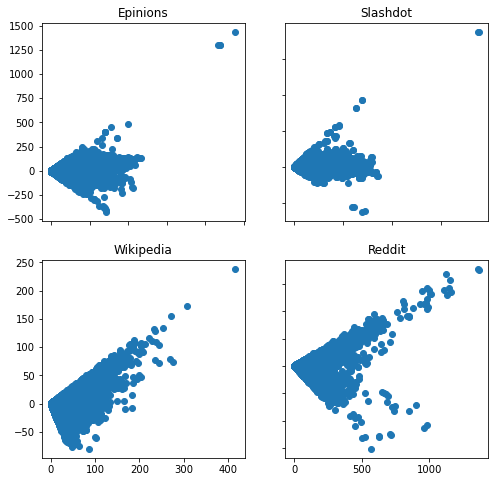

In [66]:
plot_svd(matrix_pca_X)

As the results were not exactly looking like what we could have expected, we performed t-SNE step and then plotted our results as a 2D density map.

In [67]:
from sklearn.manifold import TSNE

def compute_t_SNE(pca, n_components = 2):
    matrix_t_sne = []
    with progressbar.ProgressBar(max_value=len(matrix_pca)-1) as bar:
        for idx, matrix in enumerate(matrix_pca):
            if idx == 4:
                pass
            else:
                t_sne = TSNE(n_components=n_components, n_iter=250).fit_transform(matrix[0][:5000])
                matrix_t_sne.append(t_sne)
                bar.update(idx)
    return matrix_t_sne

In [68]:
from scipy.stats import kde
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

def twoD_density_plot(data):
    
    x = data[:,0]
    y = data[:,1]

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins = 300
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    return xi, yi, zi

def twoD_plot(matrix_t_sne):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        
    for idx in range(len(matrix_t_sne)):
        xi, yi, zi = twoD_density_plot(matrix_t_sne[idx])
        f = axs[idx//2, idx%2].pcolormesh(xi, yi, zi.reshape(xi.shape))
        if idx == 0:
            axs[idx//2, idx%2].set_title('Epinions')
        elif idx == 1:
            axs[idx//2, idx%2].set_title('Slashdot')
        elif idx == 2:
            axs[idx//2, idx%2].set_title('Wikipedia')
        else:
            axs[idx//2, idx%2].set_title('Reddit')
    
    fig.colorbar(f, ax=[axs[0,1], axs[1,1]], shrink=0.8)
    
    fig.savefig("figures/2Dplot.pdf", bbox_inches='tight')

100% (3 of 3) |##########################| Elapsed Time: 0:00:31 Time:  0:00:31


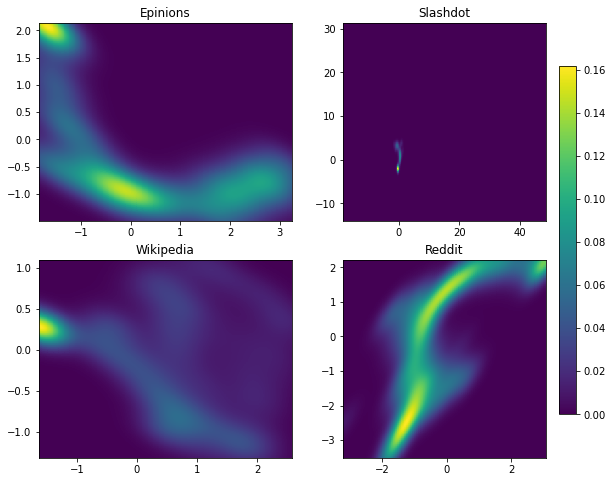

In [69]:
matrix_t_sne = compute_t_SNE(matrix_pca)
twoD_plot(matrix_t_sne)

In [70]:
if os.path.isfile("figures/2Dplot.pdf"):
    pass
else:
    matrix_t_sne = compute_t_SNE(matrix_pca)
    twoD_plot(matrix_t_sne)

From these figures, one can distinguish very dense clusters and regions with much less density, connecting them. This is particularly visible for `Wikipedia` .These images (except for the `Reddit` one), are similar to what one could have expected (that is the existence of dense cluster of users). We will now generate interactive 3D density plots.

In [71]:
from scipy import stats
import plotly.express as px

def threeD_density_plot(data):
    
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins = 300
    xyz = np.vstack([x,y,z])
    density = stats.gaussian_kde(xyz)(xyz) 
    idx = density.argsort()
    x, y, z, density = x[idx], y[idx], z[idx], density[idx]
    
    out = pd.DataFrame(np.array([x, y, z, density]).T).rename(columns={0: "X", 1: "Y", 2: "Z"})
    
    return out

def threeD_plot(matrix_t_sne):
        
    for idx in range(len(matrix_t_sne)):
        out = threeD_density_plot(matrix_t_sne[idx])
        fig = px.scatter_3d(out, x='X', y='Y', z='Z',
                      color=3)
        if idx == 0:
            fig.write_html('figures/Epinions.html')
        elif idx == 1:
            fig.write_html('figures/Slashdot.html')
        elif idx == 2:
            fig.write_html('figures/Wikipedia.html')
        else:
            fig.write_html('figures/Reddit.html')

In [72]:
matrix_t_sne = compute_t_SNE(matrix_pca, n_components = 3)
threeD_plot(matrix_t_sne)

100% (3 of 3) |##########################| Elapsed Time: 0:00:52 Time:  0:00:52


In [73]:
if (os.path.isfile('figures/Epinions.html') and os.path.isfile('figures/Slashdot.html') 
and os.path.isfile('figures/Wikipedia.html') and os.path.isfile('figures/Reddit.html')):
    pass
else:
    matrix_t_sne = compute_t_SNE(matrix_pca, n_components = 3)
    threeD_plot(matrix_t_sne)